In [8]:
import dgl
import torch
import torch.nn as nn
import torch.nn.functional as F
import itertools
import numpy as np
import scipy.sparse as sp
import sklearn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [9]:
import osmnx as ox
second_path = "europe_poland_Wroclaw_2014_v3.xml"
second_graph = ox.io.load_graphml(second_path)


In [10]:
g = dgl.from_networkx(second_graph, node_attrs=['x', 'y'], edge_attrs=['length'])

In [11]:
#g2.ndata['x'].shape
g.ndata['xy'] = torch.cat((g.ndata['x'], g.ndata['y'])).reshape((-1, 2))

In [12]:
# Split edge set for training and testing
u, v = g.edges()

eids = np.arange(g.number_of_edges())
eids = np.random.permutation(eids)
test_size = int(len(eids) * 0.3)
train_size = g.number_of_edges() - test_size
test_pos_u, test_pos_v = u[eids[:test_size]], v[eids[:test_size]]
train_pos_u, train_pos_v = u[eids[test_size:]], v[eids[test_size:]]

# Find all negative edges and split them for training and testing
adj = sp.coo_matrix((np.ones(len(u)), (u.numpy(), v.numpy())))
adj_neg = (1 - adj.todense().astype(int)) - np.eye(g.number_of_nodes()).astype(int)
neg_u, neg_v = np.where(adj_neg != 0)

neg_eids = np.random.choice(len(neg_u), g.number_of_edges())
test_neg_u, test_neg_v = neg_u[neg_eids[:test_size]], neg_v[neg_eids[:test_size]]
train_neg_u, train_neg_v = neg_u[neg_eids[test_size:]], neg_v[neg_eids[test_size:]]

In [13]:
train_g = dgl.remove_edges(g, eids[:test_size])
test_g = dgl.remove_edges(g, eids[test_size:])

In [14]:
from dgl.nn import SAGEConv

# build a two-layer GraphSAGE model
class GraphSage(nn.Module):
    def __init__(self, in_feats, h_feats):
        super(GraphSage, self).__init__()
        self.conv1 = SAGEConv(in_feats, h_feats, 'mean')
        self.conv2 = SAGEConv(h_feats, h_feats, 'mean')

    def forward(self, g, in_feat):
        h = self.conv1(g, in_feat)
        h = F.relu(h)
        h = self.conv2(g, h)
        return h

In [15]:
train_pos_g = dgl.graph((train_pos_u, train_pos_v), num_nodes=g.number_of_nodes())
train_neg_g = dgl.graph((train_neg_u, train_neg_v), num_nodes=g.number_of_nodes())

test_pos_g = dgl.graph((test_pos_u, test_pos_v), num_nodes=g.number_of_nodes())
test_neg_g = dgl.graph((test_neg_u, test_neg_v), num_nodes=g.number_of_nodes())

In [16]:
import dgl.function as fn

class DotPredictor(nn.Module):
    def forward(self, g, h):
        with g.local_scope():
            g.ndata['h'] = h
            # Compute a new edge feature named 'score' by a dot-product between the
            # source node feature 'h' and destination node feature 'h'
            g.apply_edges(fn.u_dot_v('h', 'h', 'score'))
            # u_dot_v returns a 1-element vector for each edges so you need to squeeze it.
            return g.edata['score'][:, 0]

Alternatywnie można napisać własną metodę `apply_edges`.

In [17]:
class MLPPredictor(nn.Module):
    def __init__(self, h_feats):
        super().__init__()
        self.W1 = nn.Linear(h_feats * 2, h_feats)
        self.W2 = nn.Linear(h_feats, 1)

    def apply_edges(self, edges):
        """
        Computes a scalar score for each edge of the given graph.

        Parameters
        ----------
        edges :
            Has three members ``src``, ``dst`` and ``data``, each of
            which is a dictionary representing the features of the
            source nodes, the destination nodes, and the edges
            themselves.

        Returns
        -------
        dict
            A dictionary of new edge features.
        """
        h = torch.cat([edges.src['h'], edges.dst['h']], 1)
        return {'score': self.W2(F.relu(self.W1(h))).squeeze(1)}

    def forward(self, g, h):
        with g.local_scope():
            g.ndata['h'] = h
            g.apply_edges(self.apply_edges)
            return g.edata['score']

In [22]:
from sklearn.metrics import roc_auc_score
from tqdm.notebook import tqdm_notebook
def compute_loss(pos_score, neg_score):
    scores = torch.cat([pos_score, neg_score]).to(device)
    labels = torch.cat([torch.ones(pos_score.shape[0]), torch.zeros(neg_score.shape[0])]).to(device)
    return F.binary_cross_entropy_with_logits(scores, labels)

def compute_auc(pos_score, neg_score):
    scores = torch.cat([pos_score.cpu(), neg_score.cpu()]).numpy()
    labels = torch.cat(
        [torch.ones(pos_score.shape[0]), torch.zeros(neg_score.shape[0])]
    ).numpy()
    return sklearn.metrics.roc_auc_score(labels, scores)




In [42]:
results = {}
epochs = 1000
repeats = 5
for n_feat in [4, 8, 16, 32, 64, 128]:
    model = GraphSage(train_g.ndata['xy'].shape[1], 64)
    pred = DotPredictor()
    train_g = train_g.to(device)
    model = model.to(device)
    train_pos_g = train_pos_g.to(device)
    train_neg_g = train_neg_g.to(device)
    test_pos_g = test_pos_g.to(device)
    test_neg_g = test_neg_g.to(device)
    pred = pred.to(device)
# in this case, loss will in training loop
    optimizer = torch.optim.Adam(itertools.chain(model.parameters(), pred.parameters()), lr=0.01)
    avg_aucs = np.zeros(epochs)
    for i in range(repeats):
        aucs = np.zeros(epochs)
        for e in tqdm_notebook(range(epochs)):
            # forward
            h = model(train_g, train_g.ndata['xy'])
            pos_score = pred(train_pos_g, h).to(device)
            neg_score = pred(train_neg_g, h).to(device)
            loss = compute_loss(pos_score, neg_score)

            # backward
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            with torch.no_grad():
                pos_score = pred(test_pos_g, h)
                neg_score = pred(test_neg_g, h)
                aucs[e] = compute_auc(pos_score, neg_score)
        with torch.no_grad():
            pos_score = pred(test_pos_g, h)
            neg_score = pred(test_neg_g, h)
            print('AUC', compute_auc(pos_score, neg_score))
        avg_aucs += aucs
    avg_aucs /= repeats
    results[str(n_feat)] = avg_aucs

  0%|          | 0/1000 [00:00<?, ?it/s]

AUC 0.7066925238136805


  0%|          | 0/1000 [00:00<?, ?it/s]

AUC 0.7481037978328062


  0%|          | 0/1000 [00:00<?, ?it/s]

AUC 0.7581176652493667


  0%|          | 0/1000 [00:00<?, ?it/s]

AUC 0.7611911558673331


  0%|          | 0/1000 [00:00<?, ?it/s]

AUC 0.7396958878303274


  0%|          | 0/1000 [00:00<?, ?it/s]

AUC 0.7352173194114293


  0%|          | 0/1000 [00:00<?, ?it/s]

AUC 0.7499337086025573


  0%|          | 0/1000 [00:00<?, ?it/s]

AUC 0.7525986194348576


  0%|          | 0/1000 [00:00<?, ?it/s]

AUC 0.761057773336775


  0%|          | 0/1000 [00:00<?, ?it/s]

AUC 0.7631755098872903


  0%|          | 0/1000 [00:00<?, ?it/s]

AUC 0.7246188360958403


  0%|          | 0/1000 [00:00<?, ?it/s]

AUC 0.7554717625831824


  0%|          | 0/1000 [00:00<?, ?it/s]

AUC 0.7522695388485104


  0%|          | 0/1000 [00:00<?, ?it/s]

AUC 0.7609871989442953


  0%|          | 0/1000 [00:00<?, ?it/s]

AUC 0.7641937892965556


  0%|          | 0/1000 [00:00<?, ?it/s]

AUC 0.7125615163217021


  0%|          | 0/1000 [00:00<?, ?it/s]

AUC 0.7436853190588645


  0%|          | 0/1000 [00:00<?, ?it/s]

AUC 0.7557697051722445


  0%|          | 0/1000 [00:00<?, ?it/s]

AUC 0.7606168483482652


  0%|          | 0/1000 [00:00<?, ?it/s]

AUC 0.5881605343046798


  0%|          | 0/1000 [00:00<?, ?it/s]

AUC 0.6909960479130824


  0%|          | 0/1000 [00:00<?, ?it/s]

AUC 0.7463557459387309


  0%|          | 0/1000 [00:00<?, ?it/s]

AUC 0.7563617954069495


  0%|          | 0/1000 [00:00<?, ?it/s]

AUC 0.7587467713865086


  0%|          | 0/1000 [00:00<?, ?it/s]

AUC 0.7619973167925536


  0%|          | 0/1000 [00:00<?, ?it/s]

AUC 0.7278909165894607


  0%|          | 0/1000 [00:00<?, ?it/s]

AUC 0.7402266477654968


  0%|          | 0/1000 [00:00<?, ?it/s]

AUC 0.7599036665776335


  0%|          | 0/1000 [00:00<?, ?it/s]

AUC 0.7643956389313004


  0%|          | 0/1000 [00:00<?, ?it/s]

AUC 0.7634807291587257


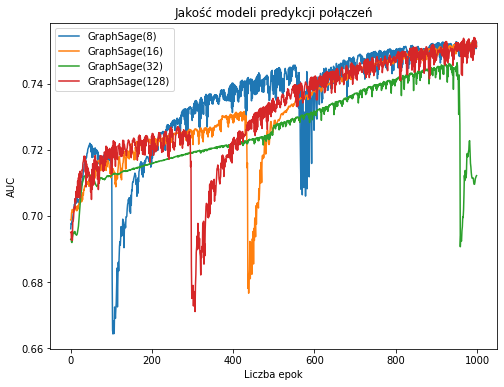

In [62]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

fig, ax = plt.subplots(figsize=(8,6))
skip = False
for n_features, auc_scores in results.items():
    if n_features in ['8', '16', '32', '128']:
        sns.lineplot(range(1000), auc_scores, ax=ax, label='GraphSage('+n_features+')')

ax.set_title('Jakość modeli predykcji połączeń')
ax.set_xlabel('Liczba epok')
ax.set_ylabel('AUC')
fig.show()